In [31]:
import numpy as np
import scipy.io as sio
import datetime
import _helper_functions as _helper
import matplotlib.pyplot as plt
plt.rcParams.update({
    "figure.facecolor":  "white",  
    "savefig.facecolor": "white",  
})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec
import matplotlib.path as mpath
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cmocean
import gvpy

import warnings
import pandas as pd
import gsw

warnings.filterwarnings("ignore")  # suppress some warnings about future code changes

# Import the necessary libraries
import mooring
import location
import ctd_cast

In [24]:
ONE_COLUMN_WIDTH = 8.3
TWO_COLUMN_WIDTH = 12
GOLDEN_RATIO = 1.61
cm = 1/2.54  # centimeters in inches

In [25]:
ls

avrg_vertical_eps.png  eps_transect.svg             _helper_functions.py
avrg_vertical_eps.svg  figure_avrg_vertical_eps.py  location.py
ctd_cast.py            figure_eps_transect.py       mooring.py
eps_transect.png       figure_introduction.ipynb    __pycache__/


In [26]:
# Load Data

# load all 7 moorings as dataframes
list_of_moorings = _helper.IO.load_pickle(name="/home/ole/Desktop/Paper1_Figures/data/list_of_moorings")

# load Stratification information
N_table = pd.read_pickle("/home/ole/Desktop/CTD/N_values.pkl")


data = np.load("/home/ole/Desktop/Paper1_Figures/data/max_depth_dict.npz", allow_pickle = True)
max_depth_dict = data["max_depth_dict"].item()

# Get CTD Data
columns = ['Event', 'Date/Time', 'Latitude', 'Longitude',
       'Depth water [m]', 'Press [dbar]', 'Temp [°C]', 'Sal', 'Expedition']
CTDs = pd.DataFrame(columns=columns)

#definition of box around the transect 
m = (63.21 - 64.22)/(53.8 - 47)
b = 63.21 - m * 53.8
shift = 0.12

def get_PS129_CTD_data():
    from location import Location
    from ctd_cast import CTDCast
    
    #get location of CTD files from the LADCP data files
    LADCP_DIRECTORY = f"/media/sf_VM_Folder/PS129_Plots/ladcp_profiles/"

    ladcp_paths = sorted(_helper.IO.get_filepaths_from_directory(LADCP_DIRECTORY, inclusive = (".mat",)))

    #all CTD cast can be identified by a number
    ladcp_cast_numbers = [path.split('/')[-1][7:-4] for path in ladcp_paths]

    #create list of all CTD cast locations
    ctd_locations = []
    ctd_timestamps = []
    for path in ladcp_paths:
        data_struct = sio.loadmat(path) 
        data = data_struct["dr"][0][0]
        lat = np.round(np.squeeze(data["lat"]),3)
        lon = np.round(np.squeeze(data["lon"]),3)
        ctd_locations.append(Location(lat = lat, lon = lon))
        time_stamp = datetime.datetime(*map(int, np.squeeze(data["date"]))) #convert list of values to datetime object
        ctd_timestamps.append(time_stamp)
        
    # Set up conversion from ID number to cast name    
    def load_stations(path):
        transect_names, transect_numbers = np.loadtxt(path, dtype = (str), delimiter = "\t", unpack = True)
        translate = dict(zip(transect_names, transect_numbers))
        #print(translate)
        return translate
    name_to_number_dict = load_stations("/media/sf_VM_Folder/PS129_Plots/conversion.txt")
    number_to_name_dict = {int(v): k for k, v in name_to_number_dict.items()}    

    #create as many CTDCast objects as casts itself
    list_of_PS129_casts= [CTDCast() for _ in ladcp_cast_numbers]

    # for every cast object set a location and a name
    for i,cast in enumerate(list_of_PS129_casts):
        cast_number = ladcp_cast_numbers[i]
        cast_name = number_to_name_dict[int(cast_number)]
        cast.name = cast_name
        cast.location = ctd_locations[i]
        cast.date = ctd_timestamps[i]

    column_names = ['Event', "Latitude", "Longitude", "Press [dbar]", "Sal", "Temp [°C]", "Absolute Salinity", "Conservative Temperature", "Date/Time", "Depth water [m]", "Expedition"]
    data_dict = {name:[] for name in column_names}

    for cast in list_of_PS129_casts:
        #load actual data to that Cast name
        try:   
            path = f"/media/sf_VM_Folder/PS129_Plots/ctd_profiles/dps129_{cast.name}.cnv"
        
            #SP = Practical Salinity [PSU]
            #Temperature [ITS-90, °C]

            #add the cast data to the data dictionary
            pressure,in_situ_temperature,practical_salinity = np.genfromtxt(path, skip_header = 322, usecols = (0,1,5), unpack = True)
            data_dict["Event"].extend([f"PS129_{cast.name}"] * len(pressure))
            data_dict["Latitude"].extend([cast.location.lat] * len(pressure))
            data_dict["Longitude"].extend([cast.location.lon] * len(pressure))
            data_dict["Press [dbar]"].extend(pressure)
            data_dict["Temp [°C]"].extend(in_situ_temperature)
            data_dict["Sal"].extend(practical_salinity)
            data_dict["Date/Time"].extend([cast.date] * len(pressure))
            data_dict["Expedition"].extend(["PS129"] * len(pressure))
            
            #add new attributes
            SA = gsw.SA_from_SP(SP = practical_salinity, p = pressure, lon = cast.location.lon, lat = cast.location.lat)
            data_dict["Absolute Salinity"].extend(SA)
            data_dict["Conservative Temperature"].extend(gsw.CT_from_t(SA = SA, t = in_situ_temperature, p = pressure))
            data_dict["Depth water [m]"].extend(np.abs(gsw.z_from_p(p = pressure, lat = cast.location.lat)))
        
        except ValueError as e:
            print("Error at ",cast.name, cast.location)
            print(e)
            continue
        #print(cast.name)     
    #print(data_dict)
    #for (k,v) in data_dict.items():
    #    print(k,len(v))
    return pd.DataFrame(data = data_dict)

PS129_CTDs = get_PS129_CTD_data()
CTDs = CTDs.merge(PS129_CTDs, on = columns, how = "outer")
#Drop all rows that are not even close to the moorings
CTDs.drop(CTDs[CTDs.Latitude < -64.5].index, inplace = True)
CTDs.drop(CTDs[CTDs.Latitude > -63].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude < -54].index, inplace = True)
CTDs.drop(CTDs[CTDs.Longitude > -47].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b+shift < CTDs.Latitude
].index, inplace = True)

CTDs.drop(CTDs[
    m*CTDs.Longitude-b-shift > CTDs.Latitude 
].index, inplace = True)

CTDs.reset_index(inplace = True, drop=True)

def find_line_number(filename, target_string):
    with open(filename, 'r') as file:
        for line_number, line in enumerate(file):
            if line.startswith(target_string):
                return line_number
    return None

data_paths = _helper.IO.get_filepaths_from_directory(directory = "/media/sf_VM_Folder/data/CTD", inclusive = ".tab", exclusive = ())
#for p in data_paths: print(p)

for i, path in enumerate(data_paths):
    target_string = "Event\tDate/Time\tLatitude\tLongitude\tElevation [m]"
    skiprows = find_line_number(path, target_string)
    if skiprows == None:
        target_string = "Event	Type	Date/Time	Longitude"
        skiprows = find_line_number(path, target_string)

    data = pd.read_csv(path, delimiter = "\t", skiprows= skiprows)
    
    data = data[data.columns.intersection(columns)]
    
    #Drop all rows that are not even close to the moorings
    data.drop(data[data.Latitude < -64.5].index, inplace = True)
    data.drop(data[data.Latitude > -63].index, inplace = True)
    data.drop(data[data.Longitude < -54].index, inplace = True)
    data.drop(data[data.Longitude > -47].index, inplace = True)

    data.drop(data[
        m*data.Longitude-b+shift < data.Latitude
    ].index, inplace = True)
    
    data.drop(data[
        m*data.Longitude-b-shift > data.Latitude 
    ].index, inplace = True)
            
    data.reset_index(inplace = True, drop=True)
    
    data['Date/Time'] =  pd.to_datetime(data['Date/Time'])#, format='%d%b%Y:%H:%M:%S.%f')
    data['Event'] = data['Event'].astype('category')
    
    try:
        if data['Event'].iloc[0][4] != "/": 
            current_expedition = data['Event'].iloc[0][0:5]
        else:
            current_expedition = data['Event'].iloc[0][0:4]
        print(current_expedition, path)
        data['Expedition'] = current_expedition
        CTDs = CTDs.merge(data, on = columns, how = "outer")  
        assert not data.empty
    
    except IndexError as e:
        print(f"Error loading {path}")
        assert data.empty
        continue

        
CTDs['Event'] = CTDs['Event'].astype('category')    
CTDs['Expedition'] = CTDs['Expedition'].astype('category')  

CTDs_grouped = CTDs.groupby("Event")
events = CTDs_grouped.groups.keys()

# Show Overview

CTDs_grouped = CTDs.groupby("Event")
events = CTDs_grouped.groups.keys()

Error at  018_07 (-59.09,0.12)
Some errors were detected !
    Line #323 (got 1 columns instead of 3)
PS18 /media/sf_VM_Folder/data/CTD/ANT-IX_2_phys_oce.tab
PS16 /media/sf_VM_Folder/data/CTD/ANT-VIII_2_phys_oce.tab
PS40 /media/sf_VM_Folder/data/CTD/ANT-XIII_4_phys_oce.tab
Error loading /media/sf_VM_Folder/data/CTD/ANT-XIV_3_phys_oce.tab
PS49 /media/sf_VM_Folder/data/CTD/ANT-XV_4_phys_oce.tab
PS67 /media/sf_VM_Folder/data/CTD/ANT-XXII_3_phys_oce.tab
PS71 /media/sf_VM_Folder/data/CTD/ANT-XXIV_3_phys_oce.tab
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_2_phys_oce.tab
Error loading /media/sf_VM_Folder/data/CTD/ANT-XXIX_3_phys_oce.tab
PS81 /media/sf_VM_Folder/data/CTD/ANT-XXIX_6_phys_oce.tab
PS77 /media/sf_VM_Folder/data/CTD/ANT-XXVII_2_phys_oce.tab
Error loading /media/sf_VM_Folder/data/CTD/ANT-X_4_phys_oce.tab
PS23 /media/sf_VM_Folder/data/CTD/ANT-X_7_phys_oce.tab
PS103 /media/sf_VM_Folder/data/CTD/PS103_phys_oce.tab
PS117 /media/sf_VM_Folder/data/CTD/PS117_phys_oce.tab


In [28]:
# # Load Bathymetry
#bat_data = sio.loadmat("/media/sf_VM_Folder/data/out.mat") 
bat_data = sio.loadmat("/media/sf_VM_Folder/data/WeddellSea_Bat.mat") 
bat_lat = bat_data["lat"]
bat_lon = bat_data["lon"]
bat_z = bat_data["z"]

# load temperature data 
data = np.load("/home/ole/Desktop/Paper1_Figures/data/poster_temperature_data.npz") 
bounds = data["bounds"]
lon_array = data["lon_array"]
z_array = data["z_array"]
temperature_array = data["temperature_array"]
uv_lon = data["uv_lon"]
uv_mab = data["uv_mab"]

        
# load N data        
N_table = pd.read_pickle("/home/ole/Desktop/Paper1_Figures/data/poster_N_values.pkl") 

# load transect bathymetry
data = np.load("/home/ole/Desktop/Paper1_Figures/data/transect_bathymetry.npz")
transect_depth = data["depth"]
transect_lon = data["lon"]

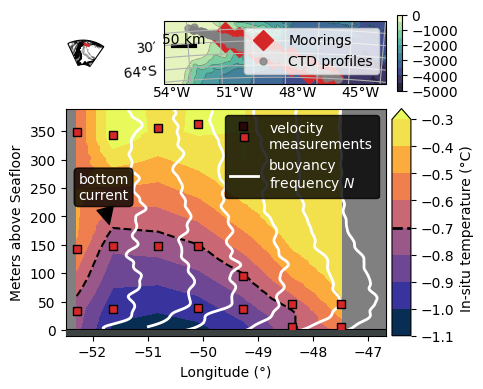

In [33]:
fig = plt.figure(layout="constrained",  figsize=(TWO_COLUMN_WIDTH*cm, 0.8*TWO_COLUMN_WIDTH*cm))

gs = GridSpec(nrows = 4, ncols = 4, figure=fig)
high_res_proj = ccrs.SouthPolarStereo(central_longitude=-55)
high_res_proj.threshold = 1e3
ax0 = fig.add_subplot(gs[:1,:1], projection=high_res_proj)
ax1 = fig.add_subplot(gs[:1, 1:], projection = ccrs.SouthPolarStereo(central_longitude=-50))
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1:, :])

# ax0
######################################################################################################
# Define the projection for a high-resolution South Polar Stereographic map


# Add the land feature to the map with specified appearance
ax0.add_feature(cfeature.LAND,
        facecolor= "grey", #feat.COLORS['land'],
        edgecolor='black',
        linewidth=1.2,
        zorder = 10)


# Define the limits for the x-axis and y-axis of the map
xlim = [-80, -20] # longitude
ylim = [-60, -80] # latitude

# Define a rectangular path for the map extent using matplotlib's Path object
rect = mpath.Path([[xlim[0], ylim[0]],
                   [xlim[1], ylim[0]],
                   [xlim[1], ylim[1]],
                   [xlim[0], ylim[1]],
                   [xlim[0], ylim[0]],
                   ])

# Transform the rectangular path to the data coordinate system
proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax0) - ax0.transData
rect_in_target = proj_to_data.transform_path(rect)

# Set the boundary of the map using the transformed rectangular path
ax0.set_boundary(rect_in_target)

"""
# Configure gridlines for the map
gl = ax0.gridlines(
    draw_labels=["top", "right", "x", "y"],
    rotate_labels=True, x_inline=False)

# Draw latitude and longitude gridlines (and their labels)
# only at the specified values
lathelp = np.arange(-75, -60, 5)
gl.ylocator = mticker.FixedLocator(lathelp)
lonhelp = np.arange(-80, -10, 10)
gl.xlocator = mticker.FixedLocator(lonhelp)

# Rotate the longitude labels to be more readable
gl.xlabel_style = {'rotation': 30}
"""

# To make sure that all of the wanted map extent is visible in the figure,
# (especially because the chosen map projections differs strongly
# at the poles from the PlateCarree Projection)
# this hack of adding a constant is needed and may need be adjusted,
# dependent on your map extent and figure size
ax0.set_extent([xlim[0], xlim[1], ylim[0] + 4, ylim[1]])
levels = [-5000,-4000, -3000, -2000, -1000, 0]
ax0.contour(bat_lon, bat_lat, bat_z, levels = levels, linewidths=0.5, linestyles='solid', colors=['black'], alpha=0.4, vmax = 0, vmin = -5000, transform=ccrs.PlateCarree())


#draw scale bar
#gvpy.maps.cartopy_scale_bar(ax0, location = (0.1,0.76), length = 500)

ax0.plot([-55, -45], [-63, -64],
         color='tab:red', lw = 2,
         transform=ccrs.Geodetic())

#ax1
######################################################################################################
#ax1.coastlines(resolution='50m')
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'rotation': 0}

ax1.set_extent([-55, -45, -63, -64.3], ccrs.PlateCarree())

#ax1.set_title("Mooring Locations in the Weddell Sea, Antarctica")
#divnorm = mcolors.TwoSlopeNorm(vcenter=0, vmin = -4000, vmax = 1000)
bat_max, bat_min  = 0, -5000
bat_z[bat_z > bat_max] = np.nan
bat_z[bat_z < bat_min] = np.nan

levels = np.arange(-5000,500,500)
image = ax1.contourf(bat_lon, bat_lat, bat_z, levels ,transform=ccrs.PlateCarree(), cmap = cmocean.cm.deep_r, vmax = bat_max, vmin = bat_min)
plt.colorbar(image, ax = ax1, orientation = "vertical", aspect = 15) #, shrink=0.5)
ax1.contour(bat_lon, bat_lat, bat_z, levels, linewidths=0.5, linestyles='solid', colors=['black'], alpha=0.4, vmax = bat_max, vmin = bat_min, transform=ccrs.PlateCarree())

for mooring in list_of_moorings:
    ax1.plot(mooring.location.lon, mooring.location.lat, "D", c = "tab:red", markersize = 15 , transform = ccrs.PlateCarree())

ax1.plot(-mooring.location.lon, -mooring.location.lat, "D", c = "tab:red", markersize = 10 , transform = ccrs.PlateCarree(), label = "Moorings")
    
color = "grey"
markersize = 10  

for event in events:
    profile = CTDs_grouped .get_group(event).reset_index(drop = True)
    ax1.plot(profile["Longitude"].iloc[0],
        profile["Latitude"].iloc[0],
        ".",
        markersize = markersize,
        color = color,
        alpha = 0.8,
        #markeredgewidth=1,
        #markeredgecolor = "black",
        transform=ccrs.PlateCarree())

ax1.plot(-profile["Longitude"].iloc[0],
    -profile["Latitude"].iloc[0],
    ".",
    markersize = markersize,
    color = color,
    alpha = 0.8,
    #markeredgewidth=1,
    #markeredgecolor = "black",
    transform=ccrs.PlateCarree(), label = "CTD profiles")

ax1.legend()

gvpy.maps.cartopy_scale_bar(ax1, location = (0.04,0.6), length = 50) 

# Turn off some axis ticks
#ax1.tick_params(axis='both', which='both', left=True, right=False, bottom=True, top=False, labelbottom=True)

#ax2
######################################################################################################
ax2.set_facecolor('grey')

# Draw temperature background
bounds = np.arange(-1.1,-0.2,0.1)
tric = ax2.tricontourf(lon_array,z_array,temperature_array, levels = bounds, extend = "max", cmap = cmocean.cm.thermal)
level = -0.7
ax2.tricontour(lon_array,z_array,temperature_array, levels = [level], colors = "black")
ax2.annotate('bottom\ncurrent', xy=(-51.69, 184), xytext=(-51.8, 230),
            arrowprops=dict(facecolor='black', width = 2, shrink=0.05), ha = "center", color = "white", bbox=dict(facecolor='black', alpha = 0.8, edgecolor='black', boxstyle='round'))
            

#draw measurement positions
ax2.plot(uv_lon,uv_mab+5,"s", label = "velocity\nmeasurements", color = "tab:red", markersize = 6, markeredgecolor = "k", zorder = 5)
ax2.set_ylim(-10,390)
xlim = ax2.get_xlim()
ax2.set_xlim((xlim[0]-0.2,xlim[1]+0.8))
ax2.set_xlabel("Longitude (°)")
ax2.set_ylabel("Meters above Seafloor")
cb = plt.colorbar(tric, ax = ax2, pad = 0.02, aspect = 12)
cb.set_label(r"In-situ temperature (°C)")
cb.ax.plot([0, 1], [-0.7,-0.7], 'k--', lw = 2)


# draw N profiles
factor = 600 #exaggeration in the x-direction
columns = list(N_table.columns)[2:]
lons = sorted(list(set(uv_lon))[1:])
for column,l in zip(columns,lons):
    if column == "mab": continue
    #print(l,column)
    mean = factor*N_table[column][:100].mean()
    ax2.plot(factor*N_table[column][:200]+l-factor*0.0005, N_table["mab"][:200],c = "w", lw = 2)   
    
    
#only once for the legend, not visible, not part of the loop  
ax2.plot(factor*N_table[column][:200]+l-factor*0.0005, -50-1*N_table["mab"][:200], 
    label = "buoyancy\nfrequency $N$", 
    c = "w", lw = 2
    )



#draw sea floor
x = list(ax2.get_xlim())
y1 = [0,0]
y2 = 2*list(ax2.get_ylim())[0]
ax2.axhline(0, c="k")
ax2.fill_between(x,y1,y2, facecolor = "xkcd:charcoal grey", zorder = 5)#, hatch="///")

"""
#draw second axis with depths
lons = sorted(list(set(uv_lon)))
depth_labels = []
for l in lons:
    local_depth = transect_depth[np.argmin(np.abs(transect_lon - l))]
    depth_labels.append(f"{local_depth:.0f}")


ax2b = ax2.secondary_xaxis(location="top")
ax2b = helper.Plot._axstyle(ax2, ticks="out", grid=False)#, spine_offset=40) 
ax2b.xaxis.set_ticks([])
ax2b.xaxis.set_ticklabels([])
ax2b.minorticks_off()
ax2b.xaxis.set_ticks(lons)
ax2b.xaxis.set_ticklabels(depth_labels)
ax2b.set_xlabel("Depth (m)")
"""
#ax2.set_title("Cross section through the gravity current")
ax2.legend(loc = "upper right",facecolor='k', framealpha=0.8, edgecolor = "black", labelcolor = "white")

#fig.tight_layout()
    
#plt.savefig(f"./figures/Intro_figure.png", dpi=800, bbox_inches='tight')
#plt.savefig(f"./figures/Intro_figure.svg", bbox_inches='tight')
#plt.show()     